### Importing Data through keras library

In [1]:
from tensorflow.keras.datasets import imdb
import numpy as np

vocabulary_size = 4000 
n = 100  # Αριθμός πιο συχνών λέξεων που θα αφαιρεθούν
k = 50   # Αριθμός πιο σπάνιων λέξεων που θα αφαιρεθούν
m = 5000 # Αριθμός λέξεων με το υψηλότερο πληροφοριακό κέρδος

# Load the dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = vocabulary_size)
word_index = imdb.get_word_index() # dictionary mapping words to their corresponding integer indices
index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'
x_train_text = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
x_test_text = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])

### Create a Vocabulary

In [2]:
from collections import Counter

vocabulary = Counter()
for text in x_train_text:
    tokens = text.split()
    vocabulary.update(tokens)

most_common_words = [word for word, _ in vocabulary.most_common(n)]
least_common_words = [word for word, _ in vocabulary.most_common()[:-k-1:-1]]

filtered_vocabulary = [word for word in vocabulary.keys() 
                       if word not in most_common_words and word not in least_common_words]

filtered_vocabulary = list(filtered_vocabulary)


### Create Binary Vectors

In [3]:
from tqdm import tqdm
from sklearn.feature_selection import mutual_info_classif

def create_binary_vectors(texts, vocabulary):
  binary_vectors = []

  for text in tqdm(texts):
    tokens = text.split()
    b_vector = list()
    for vocab_token in vocabulary:
      if vocab_token in tokens:
        b_vector.append(1)
      else:
        b_vector.append(0)
    binary_vectors.append(b_vector)

  return np.array(binary_vectors)

x_train_binary = create_binary_vectors(x_train_text, filtered_vocabulary)

# πληροφοριακο κερδος
mutual_info = mutual_info_classif(x_train_binary, y_train, discrete_features=True)
# Επιλογή m λέξεων με το υψηλότερο πληροφοριακό κέρδος
top_m_indices = np.argsort(mutual_info)[-m:]
final_vocabulary = [filtered_vocabulary[i] for i in top_m_indices]

# Μετατροπή των δεδομένων σε διανύσματα βάσει του τελικού λεξιλογίου
x_train_binary_final = create_binary_vectors(x_train_text, final_vocabulary)
x_test_binary_final = create_binary_vectors(x_test_text, final_vocabulary)

100%|██████████| 25000/25000 [03:10<00:00, 130.92it/s]


### Implementing the Naive Bayes Classification algorithm

In [4]:
class BernoulliNaiveBayes:
    def __init__(self):
        self.class_priors = {}  # Prior P(C)
        self.feature_probs = {}  # Likelihood P(X | C)

    def fit(self, X, y):
        """
        Train the Bernoulli Naive Bayes classifier.
        :param X: Binary feature matrix (num_samples, num_features)
        :param y: Labels (num_samples,)
        """
        n_samples, n_features = X.shape
        unique_classes = np.unique(y)

        # Calculate priors P(C)
        for cls in unique_classes:
            class_count = np.sum(y == cls)
            self.class_priors[cls] = class_count / n_samples

        # Calculate likelihoods P(X | C)
        for cls in unique_classes:
            # Select samples belonging to this class
            X_class = X[y == cls]
            # Compute probabilities for each feature
            feature_prob = (np.sum(X_class, axis=0) + 1) / (X_class.shape[0] + 2)  # Laplace smoothing
            self.feature_probs[cls] = feature_prob

    def predict(self, X):
        """
        Predict the class for each sample in X.
        :param X: Binary feature matrix (num_samples, num_features)
        :return: Predicted labels
        """
        predictions = []

        for x in X:
            class_scores = {}
            for cls in self.class_priors:
                # Start with the log prior
                score = np.log(self.class_priors[cls])

                # Add the log likelihoods
                feature_prob = self.feature_probs[cls]
                score += np.sum(np.log(feature_prob) * x + np.log(1 - feature_prob) * (1 - x))
                class_scores[cls] = score

            # Choose the class with the highest score
            predictions.append(max(class_scores, key=class_scores.get))

        return np.array(predictions)


# Training the Bernoulli Naive Bayes classifier
nb_classifier = BernoulliNaiveBayes()
nb_classifier.fit(x_train_binary_final, y_train)

# Testing the classifier
y_pred = nb_classifier.predict(x_test_binary_final)

# Evaluate accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.85


### Diagrams and Statistics

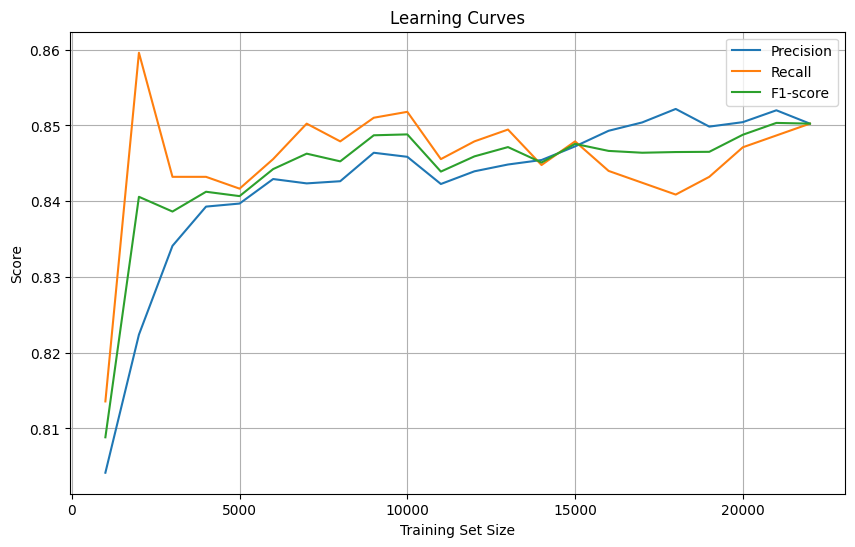

Precision (Positive): 0.8521575678326251
Recall (Positive): 0.83416
F1 (Positive): 0.8430627425614489
Precision (Negative): 0.8375900971482294
Recall (Negative): 0.85528
F1 (Negative): 0.8463426219126029
Macro-averaged Precision: 0.8448738324904272
Macro-averaged Recall: 0.84472
Macro-averaged F1: 0.8447026822370258
Micro-averaged Precision: 0.84472
Micro-averaged Recall: 0.84472
Micro-averaged F1: 0.84472


In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Δημιουργία συνάρτησης για καμπύλες μάθησης
def learning_curves(model, X_train, y_train, X_dev, y_dev, step_size=1000):
    """
    Υπολογισμός καμπυλών μάθησης για διαφορετικά μεγέθη εκπαίδευσης.
    :param model: Το μοντέλο Naive Bayes
    :param X_train: Δεδομένα εκπαίδευσης
    :param y_train: Ετικέτες εκπαίδευσης
    :param X_dev: Δεδομένα ανάπτυξης
    :param y_dev: Ετικέτες ανάπτυξης
    :param step_size: Βήμα αύξησης του μεγέθους εκπαίδευσης
    :return: Λίστες με ακρίβεια, ανάκληση, και F1-score
    """
    training_sizes = []
    precisions = []
    recalls = []
    f1_scores = []

    for i in range(step_size, len(X_train) + 1, step_size):
        # Training subset
        X_subset = X_train[:i]
        y_subset = y_train[:i]

        # Verify alignment of subset
        assert len(X_subset) == len(y_subset), "Mismatch between X_subset and y_subset lengths"

        # Εκπαίδευση του μοντέλου
        model.fit(X_subset, y_subset)

        # Πρόβλεψη στα δεδομένα ανάπτυξης
        y_pred = model.predict(X_dev)

        # Υπολογισμός ακρίβειας, ανάκλησης, και F1
        precision = precision_score(y_dev, y_pred, average='binary')
        recall = recall_score(y_dev, y_pred, average='binary')
        f1 = f1_score(y_dev, y_pred, average='binary')

        # Αποθήκευση αποτελεσμάτων
        training_sizes.append(i)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    return training_sizes, precisions, recalls, f1_scores

# Δημιουργία γραφημάτων
def plot_learning_curves(training_sizes, precisions, recalls, f1_scores):
    plt.figure(figsize=(10, 6))
    plt.plot(training_sizes, precisions, label="Precision")
    plt.plot(training_sizes, recalls, label="Recall")
    plt.plot(training_sizes, f1_scores, label="F1-score")
    plt.xlabel("Training Set Size")
    plt.ylabel("Score")
    plt.title("Learning Curves")
    plt.legend()
    plt.grid()
    plt.show()

# Εφαρμογή του μοντέλου και υπολογισμός καμπυλών
nb_classifier = BernoulliNaiveBayes()

# Δημιουργία δεδομένων ανάπτυξης από τα δεδομένα εκπαίδευσης
dev_size = int(0.1 * len(x_train_binary_final))  # 10% ως development set
X_dev = x_train_binary_final[:dev_size]
y_dev = y_train[:dev_size]

X_train = x_train_binary_final[dev_size:]
y_train = y_train[dev_size:]

# Υπολογισμός καμπυλών μάθησης
training_sizes, precisions, recalls, f1_scores = learning_curves(
    nb_classifier, X_train, y_train, X_dev, y_dev
)

# Σχεδίαση καμπυλών
plot_learning_curves(training_sizes, precisions, recalls, f1_scores)

# Υπολογισμός τελικών αποτελεσμάτων στα δεδομένα αξιολόγησης
nb_classifier.fit(X_train, y_train)
y_test_pred = nb_classifier.predict(x_test_binary_final)

# Ακρίβεια, Ανάκληση και F1 για κατηγορίες και μέσα (macro, micro)
precision_pos = precision_score(y_test, y_test_pred, pos_label=1)
recall_pos = recall_score(y_test, y_test_pred, pos_label=1)
f1_pos = f1_score(y_test, y_test_pred, pos_label=1)

precision_neg = precision_score(y_test, y_test_pred, pos_label=0)
recall_neg = recall_score(y_test, y_test_pred, pos_label=0)
f1_neg = f1_score(y_test, y_test_pred, pos_label=0)

precision_macro = precision_score(y_test, y_test_pred, average="macro")
recall_macro = recall_score(y_test, y_test_pred, average="macro")
f1_macro = f1_score(y_test, y_test_pred, average="macro")

precision_micro = precision_score(y_test, y_test_pred, average="micro")
recall_micro = recall_score(y_test, y_test_pred, average="micro")
f1_micro = f1_score(y_test, y_test_pred, average="micro")

# Εκτύπωση αποτελεσμάτων
print("Precision (Positive):", precision_pos)
print("Recall (Positive):", recall_pos)
print("F1 (Positive):", f1_pos)

print("Precision (Negative):", precision_neg)
print("Recall (Negative):", recall_neg)
print("F1 (Negative):", f1_neg)

print("Macro-averaged Precision:", precision_macro)
print("Macro-averaged Recall:", recall_macro)
print("Macro-averaged F1:", f1_macro)

print("Micro-averaged Precision:", precision_micro)
print("Micro-averaged Recall:", recall_micro)
print("Micro-averaged F1:", f1_micro)

## Μερος Β

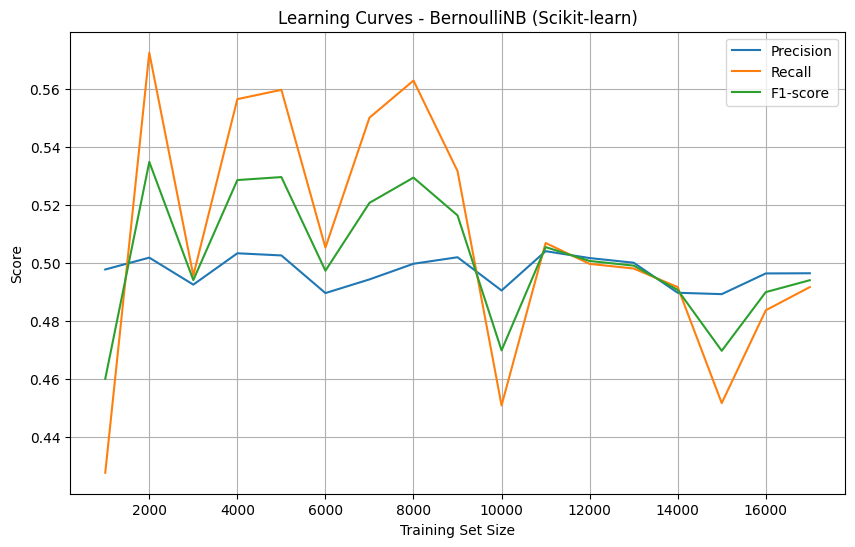

Scikit-learn BernoulliNB Results:
Macro Precision: 0.5208628349868383
Macro Recall: 0.5207999999999999
Macro F1: 0.5204389127529374


In [7]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def learning_curves_sklearn(model, X_train, y_train, X_dev, y_dev, step_size=1000):
    training_sizes, precisions, recalls, f1_scores = [], [], [], []
    
    for i in range(step_size, min(len(X_train), len(y_train)) + 1, step_size):
        X_subset, y_subset = X_train[:i], y_train[:i]
        model.fit(X_subset, y_subset)
        y_pred = model.predict(X_dev)
        
        precisions.append(precision_score(y_dev, y_pred, average='binary'))
        recalls.append(recall_score(y_dev, y_pred, average='binary'))
        f1_scores.append(f1_score(y_dev, y_pred, average='binary'))
        training_sizes.append(i)
    
    return training_sizes, precisions, recalls, f1_scores

def plot_learning_curves(training_sizes, precisions, recalls, f1_scores):
    plt.figure(figsize=(10, 6))
    plt.plot(training_sizes, precisions, label="Precision")
    plt.plot(training_sizes, recalls, label="Recall")
    plt.plot(training_sizes, f1_scores, label="F1-score")
    plt.xlabel("Training Set Size")
    plt.ylabel("Score")
    plt.title("Learning Curves - BernoulliNB (Scikit-learn)")
    plt.legend()
    plt.grid()
    plt.show()

# Διαίρεση σε training και development set
dev_size = int(0.1 * len(x_train_binary_final))
X_dev, y_dev = x_train_binary_final[:dev_size], y_train[:dev_size]
X_train, y_train = x_train_binary_final[dev_size:], y_train[dev_size:]

# Διασφάλιση συμβατών μεγεθών
dev_size = min(len(X_dev), len(y_dev))
train_size = min(len(X_train), len(y_train))
X_dev, y_dev = X_dev[:dev_size], y_dev[:dev_size]
X_train, y_train = X_train[:train_size], y_train[:train_size]

# Εκπαίδευση και αξιολόγηση του BernoulliNB του Scikit-learn
sklearn_nb = BernoulliNB(binarize=None)
training_sizes, precisions, recalls, f1_scores = learning_curves_sklearn(
    sklearn_nb, X_train, y_train, X_dev, y_dev
)
plot_learning_curves(training_sizes, precisions, recalls, f1_scores)

# Τελική αξιολόγηση στο test set
sklearn_nb.fit(X_train, y_train)
y_test_pred = sklearn_nb.predict(x_test_binary_final[:len(y_test)])

# Υπολογισμός μετρικών
precision_macro = precision_score(y_test[:len(y_test_pred)], y_test_pred, average="macro")
recall_macro = recall_score(y_test[:len(y_test_pred)], y_test_pred, average="macro")
f1_macro = f1_score(y_test[:len(y_test_pred)], y_test_pred, average="macro")

# Εκτύπωση αποτελεσμάτων
print("Scikit-learn BernoulliNB Results:")
print("Macro Precision:", precision_macro)
print("Macro Recall:", recall_macro)
print("Macro F1:", f1_macro)
